# Earthquakes and oil miming in Oklahoma
The earthquakes in the Parkerfield region are due to stress release as the tectonic plates move relative to each other along the San Andreas fault. But the frequency of earthquakes and seismicity can change due to other geological events.

Around 2010, hydraulic fracturing, known as fracking, saw a rapid rise in the US state of Oklahoma. Fracking itself does not seem to change seismic behavior, but wastewater from fracking is injected at high pressure deep into the earth, and this may cause earthquakes. 

Here, we will perform a quantitative analysis of earthquake frequencies in Oklahoma to see how they changed when fracking became widespread in 2010.

# 1 Earthquakes over time

## The dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandasql as ps
import dc_stat_think as dcst
from datetime import datetime as dt
import time as t

In [2]:
pd.set_option('max_columns', None)
df_oklahoma = pd.read_csv (r'oklahoma_earthquakes_1950-2017.csv',skiprows=2)
df_oklahoma.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,loc_name,loc_admin1,loc_admin2,loc_cc
0,1974-12-16 02:30:21.400,35.330,-97.480,10.0,2.6,ml,NaN,NaN,NaN,NaN,us,usp000094v,2014-11-06T23:21:27.851Z,"Oklahoma City urban area, Oklahoma",earthquake,NaN,NaN,NaN,NaN,reviewed,m,tul,Moore,Oklahoma,Cleveland County,US
1,1975-09-13 01:25:02.800,34.139,-97.369,5.0,3.4,lg,NaN,NaN,NaN,NaN,us,usp0000csk,2014-11-06T23:21:31.918Z,Oklahoma,earthquake,NaN,NaN,NaN,NaN,reviewed,us,tul,Wilson,Oklahoma,Carter County,US
2,1975-10-12 02:58:11.200,34.816,-97.406,20.0,3.2,lg,NaN,NaN,NaN,NaN,us,usp0000d4a,2014-11-06T23:21:32.248Z,Oklahoma,earthquake,NaN,NaN,NaN,NaN,reviewed,us,tul,Maysville,Oklahoma,Garvin County,US
3,1975-11-29 14:29:40.900,34.521,-97.347,5.0,3.5,lg,NaN,NaN,NaN,NaN,us,usp0000dsb,2014-11-06T23:21:32.839Z,Oklahoma,earthquake,NaN,NaN,NaN,NaN,reviewed,us,slm,Wynnewood,Oklahoma,Garvin County,US
4,1976-04-16 18:59:44.200,36.107,-99.875,5.0,3.4,NaN,NaN,NaN,NaN,NaN,us,usp0000fwz,2014-11-06T23:21:34.833Z,Oklahoma,earthquake,NaN,NaN,NaN,NaN,reviewed,us,tul,Arnett,Oklahoma,Ellis County,US


In [3]:
df_oklahoma['time']=pd.to_datetime(df_oklahoma['time'])

### The dataset

In [4]:
df_oklahoma_bounded=df_oklahoma[df_oklahoma['time']>='1980-01-01 00:00']
df_oklahoma_bounded=df_oklahoma_bounded[df_oklahoma_bounded['time']<='2017-07-01 00:00.000']
df_oklahoma_bounded.reset_index(inplace=True)

In [5]:
q="""SELECT mag
FROM df_oklahoma_bounded
"""
mags=ps.sqldf(q)
mags=mags.to_numpy().reshape(-1)
#print(mags)
print(len(mags))


8924


In [6]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return t.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [7]:
#df_oklahoma['decimal_year']=toYearFraction(df_oklahoma['time'])

time=np.empty(len(df_oklahoma_bounded.index))
#df_oklahoma_bounded
for index, value in df_oklahoma_bounded['time'].items():
    time[index]=toYearFraction(value)
print(len(time))

8924



[1980.83720557 1981.52570277 1982.33514999 ... 2017.4972421  2017.49814877
 2017.49845266]

# EDA: Plotting earthquakes over time

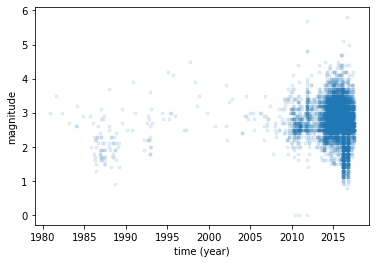

In [8]:
# Plot time vs. magnitude

_=plt.plot(time,mags,marker='.',linestyle='none', alpha=0.1)

# Label axes and show the plot
plt.xlabel('time (year)')
plt.ylabel('magnitude')
plt.show()


## Estimates of the mean interearthquake times
The graphical EDA in the last exercise shows an obvious change in earthquake frequency around 2010. To compare, compute the mean time between earthquakes of magnitude 3 and larger from 1980 through 2009 and also from 2010 through mid-2017. Also include 95% confidence intervals of the mean. The variables dt_pre and dt_post respectively contain the time gap between all earthquakes of magnitude at least 3 from pre-2010 and post-2010 in units of days.

### The dataset

In [9]:
df_oklahoma_bounded=df_oklahoma[df_oklahoma['time']>='1980-01-01 00:00']
df_oklahoma_bounded=df_oklahoma_bounded[df_oklahoma_bounded['time']<='2017-07-01 12:00.000']
df_oklahoma_bounded.reset_index(inplace=True)

In [10]:
q="""SELECT JULIANDAY(time)-JULIANDAY(LAG(time,1,0) OVER (ORDER BY time))
FROM df_oklahoma_bounded
WHERE mag>=3 AND time<'2010-01-01 00:00'
"""
dt_pre=ps.sqldf(q)
dt_pre=dt_pre.to_numpy().reshape(-1)
dt_pre=dt_pre[1:]
#print(dt_pre)
print(len(dt_pre))


52


In [11]:
q="""SELECT JULIANDAY(time)-JULIANDAY(LAG(time,1,0) OVER (ORDER BY time))
FROM df_oklahoma_bounded
WHERE mag>=3 AND time>='2010-01-01 00:00'
"""
dt_post=ps.sqldf(q)
dt_post=dt_post.to_numpy().reshape(-1)
dt_post=dt_post[1:]
#print(dt_post)
#print(len(dt_post))


### Computing mean interearthquake times

In [12]:
# Compute mean interearthquake time

mean_dt_pre = np.mean(dt_pre)
mean_dt_post = np.mean(dt_post)

# Draw 10,000 bootstrap replicates of the mean
bs_reps_pre = dcst.draw_bs_reps(dt_pre,np.mean,size=10000)
bs_reps_post = dcst.draw_bs_reps(dt_post,np.mean,size=10000)

# Compute the confidence interval
conf_int_pre = np.percentile(bs_reps_pre,[2.5,97.5])
conf_int_post = np.percentile(bs_reps_post,[2.5,97.5])

# Print the results
print("""1980 through 2009
mean time gap: {0:.2f} days
95% conf int: [{1:.2f}, {2:.2f}] days""".format(mean_dt_pre, *conf_int_pre))

print("""
2010 through mid-2017
mean time gap: {0:.2f} days
95% conf int: [{1:.2f}, {2:.2f}] days""".format(mean_dt_post, *conf_int_post))


1980 through 2009
mean time gap: 204.61 days
95% conf int: [140.77, 277.43] days

2010 through mid-2017
mean time gap: 1.12 days
95% conf int: [0.97, 1.29] days


There is almost a 200-fold increase in earthquake frequency after 2010.

## Hypothesis test: did earthquake frequency change?
Obviously, there was a massive increase in earthquake frequency once wastewater injection began. 
Nonetheless, you will still do a hypothesis test for practice. You will not test the hypothesis that the 
interearthquake times have the same distribution before and after 2010, since wastewater injection may 
affect the distribution. Instead, you will assume that they have the same mean. So, compute the p-value 
associated with the hypothesis that the pre- and post-2010 interearthquake times have the same mean, using the mean of pre-2010 time gaps minus the mean of post-2010 time gaps as your test statistic.

In [13]:
# Compute the observed test statistic
mean_dt_diff = mean_dt_pre - mean_dt_post

# Shift the post-2010 data to have the same mean as the pre-2010 data
dt_post_shift = dt_post - mean_dt_post + mean_dt_pre

# Compute 10,000 bootstrap replicates from arrays
bs_reps_pre = dcst.draw_bs_reps(dt_pre,np.mean,size=10000)
bs_reps_post = dcst.draw_bs_reps(dt_post_shift,np.mean,size=10000)

# Get replicates of difference of means
bs_reps = bs_reps_pre - bs_reps_post

# Compute and print the p-value
p_val = np.sum(bs_reps >= mean_dt_diff) / 10000
print('p =', p_val)

p = 0.0


In 10,000 samples, not one had a test statistic greater than was was observed. The p-value is, predictably based on what we have done so far, tiiiiiny!

# What about magnitudes pre and post fracking?

## EDA: Comparing magnitudes before and after 2010
Make an ECDF of earthquake magnitudes from 1980 through 2009. On the same plot, show an ECDF of magnitudes of earthquakes from 2010 through mid-2017. 

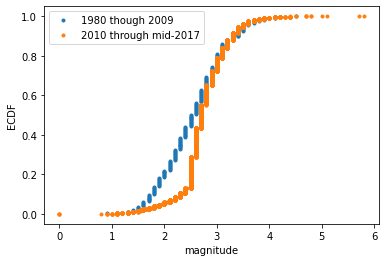

In [14]:
# Get magnitudes before and after 2010
mags_pre = mags[time < 2010]
mags_post = mags[time >= 2010]

# Generate ECDFs
_=plt.plot(*dcst.ecdf(mags_pre),marker='.',linestyle='none')
_=plt.plot(*dcst.ecdf(mags_post),marker='.',linestyle='none')

# Label axes and show plot
_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
plt.legend(('1980 though 2009', '2010 through mid-2017'), loc='upper left')
plt.show()

Both curves seem to follow the Gutenberg-Richter Law, but with different completeness thresholds, probably due to improvements in sensing capabilities in more recent years.

## Quantification of the b-values
Based on the previous plot, we can safely use a completeness threshold of mt = 3. Using this threshold, we will compute b-values for the period between 1980 and 2009 and for 2010 through mid-2017. 

In [15]:
def b_value(mags, mt, perc=[2.5, 97.5], n_reps=None):
    """Compute the b-value and optionally its confidence interval."""
    # Extract magnitudes above completeness threshold: m
    m = mags[mags >= mt]

    # Compute b-value: b
    b = (np.mean(m)-mt)*np.log(10)

    # Dranw bootstrap replicates
    if n_reps is None:
        return b
    else:
        m_bs_reps = dcst.draw_bs_reps(m,np.mean,size=n_reps)

        # Compute b-value from replicates: b_bs_reps
        b_bs_reps = (m_bs_reps - mt) * np.log(10)

        # Compute confidence interval: conf_int
        conf_int = np.percentile(b_bs_reps,perc)
    
        return b, conf_int

In [16]:
# Compute b-value and confidence interval for pre-2010
b_pre, conf_int_pre = b_value(mags_pre, mt=3, perc=[2.5, 97.5], n_reps=10000)

# Compute b-value and confidence interval for post-2010
b_post, conf_int_post = b_value(mags_post, mt=3, perc=[2.5, 97.5], n_reps=10000)

# Report the results
print("""
1980 through 2009
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]

2010 through mid-2017
b-value: {3:.2f}
95% conf int: [{4:.2f}, {5:.2f}]
""".format(b_pre, *conf_int_pre, b_post, *conf_int_post))



1980 through 2009
b-value: 0.74
95% conf int: [0.54, 0.97]

2010 through mid-2017
b-value: 0.62
95% conf int: [0.60, 0.65]



The confidence interval for the b-value for recent earthquakes is tighter than for earlier ones because there are many more recent ones. Still, the confidence intervals overlap, and we can perform a hypothesis test to see if we might get these results if the b-values are actually the same.

## How should we do a hypothesis test on differences of the b-value?

* We should only include earthquakes that have magnitudes above the completeness threshold. A value of 3 is reasonable.

* We should perform a permutation test because asserting a null hypothesis that the b-values are the same implicitly assumes that the magnitudes are identically distributed, specifically Exponentially, by the Gutenberg-Richter Law.

* A reasonable test statistic is the difference between the mean post-2010 magnitude and the mean pre-2010 magnitude.

* We do not need to worry about the fact that there were far fewer earthquakes before 2010 than there were after. That is to say, there are fewer earthquakes before 2010, but sufficiently many to do a permutation test.

* We do not need to worry about the fact that the two time intervals are of different length.


For instructional purposes, here are reasons why each is true: Option 1 is true because below the completeness threshold, we are not comparing earthquakes before and after 2010, but observed earthquakes before and after 2010. We do not have a complete data set below the completeness threshold. Option 2 is true because we really are assuming the Gutenberg-Richter law holds, in part because we are only considering earthquakes above the completeness threshold. We are using a model (the G-R law) to deal with missing data. So, since both sets of quakes follow the same statistical model, and that model has a single parameter, a permutation test is appropriate. Option 3 is true, even though you may be thinking that the mean values are not the b-values, and that you should be using the difference in b-value as your test statistic. However, the difference in mean magnitude is directly proportional to the difference in b-value, so the result of the hypothesis test will be identical if we use b-values of mean magnitudes. Option 4 is true because even though they have different numbers of earthquakes, you are only interested in summary statistics about their magnitude. There were 53 earthquakes between 1980 and 2009 with magnitude 3 or greater, so we have enough to compute a reliable mean. Option 5 is true because, provided the time interval is long enough, the b-value is independent of the time interval, just like the mean of Exponentially distributed values is independent of how many there are, provided there are not too few.

## Hypothesis test: are the b-values different?


In [18]:
# Only magnitudes above completeness threshold
mags_pre = mags_pre[mags_pre >= 3]
mags_post = mags_post[mags_post >= 3]

# Observed difference in mean magnitudes: diff_obs
diff_obs = np.mean(mags_post) - np.mean(mags_pre)

# Generate permutation replicates: perm_reps
perm_reps = dcst.draw_perm_reps(mags_post,mags_pre,dcst.diff_of_means,size=10000)

# Compute and print p-value
p_val = np.sum(perm_reps < diff_obs) / 10000
print('p =', p_val)

p = 0.104


A p-value around 0.1 suggests that the observed magnitudes are commensurate with there being no change in b-value after wastewater injection began.